In [1]:
import os 
import glob
import numpy as np
import cv2
from mediapipe import python as mp
from scipy import sparse
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt

def data_reader(data_path):
    
    subject = []
    ground_truth_PPG = []
    Forehead_rPPG_POS = []
    Right_Cheek_rPPG_POS = []
    Left_Cheek_rPPG_POS = []
    Forehead_rPPG_CHROM = []
    Right_Cheek_rPPG_CHROM = []
    Left_Cheek_rPPG_CHROM = []

    for folder in os.listdir(data_path):
        
        folder_path = os.path.join(data_path, folder)

        if os.path.isdir(folder_path):
            
            video_file_path = os.path.join(folder_path, 'vid.avi')
            ground_truth_path = os.path.join(folder_path, 'ground_truth.txt')
            
            Y_PPG = read_ground_truth(ground_truth_path)
            fps, forehead_RGB, right_cheek_RGB, left_cheek_RGB = read_video(video_file_path)

            X_Forehead_rPPG_POS = normalize_zero_mean(POS_WANG(forehead_RGB, fps))
            X_Right_Cheek_rPPG_POS = normalize_zero_mean(POS_WANG(right_cheek_RGB, fps))
            X_Left_Cheek_rPPG_POS = normalize_zero_mean(POS_WANG(left_cheek_RGB, fps))

            X_Forehead_rPPG_CHROM = normalize_zero_mean(CHROME_DEHAAN(forehead_RGB, fps))
            X_Right_Cheek_rPPG_CHROM = normalize_zero_mean(CHROME_DEHAAN(right_cheek_RGB, fps))
            X_Left_Cheek_rPPG_CHROM = normalize_zero_mean(CHROME_DEHAAN(left_cheek_RGB, fps))

            #X_rPPG = [Forehead_rPPG_POS, Right_Cheek_rPPG_POS, Left_Cheek_rPPG_POS, Forehead_rPPG_CHROM, Right_Cheek_rPPG_CHROM, Left_Cheek_rPPG_CHROM]
            subject.append(folder)
            ground_truth_PPG.append(Y_PPG)
            Forehead_rPPG_POS.append(X_Forehead_rPPG_POS)
            Right_Cheek_rPPG_POS.append(X_Right_Cheek_rPPG_POS)
            Left_Cheek_rPPG_POS.append(X_Left_Cheek_rPPG_POS)
            Forehead_rPPG_CHROM.append(X_Forehead_rPPG_CHROM)
            Right_Cheek_rPPG_CHROM.append(X_Right_Cheek_rPPG_CHROM)
            Left_Cheek_rPPG_CHROM.append(X_Left_Cheek_rPPG_CHROM)

    return subject, ground_truth_PPG, Forehead_rPPG_POS, Right_Cheek_rPPG_POS, Left_Cheek_rPPG_POS, Forehead_rPPG_CHROM, Right_Cheek_rPPG_CHROM, Left_Cheek_rPPG_CHROM

def read_ground_truth(path):
    file = open(path ,'r')
    data = file.readlines()
    PPG_str = data[0].split()
    PPG = list(map(float, PPG_str))
    PPG = normalize_zero_mean(detrend(np.array(PPG), 100))
    Heart_Rate_str = data[1].split()
    Heart_Rate = list(map(float, Heart_Rate_str))
    Time_str = data[2].split()
    Time = list(map(float, Time_str))
    file.close()
    return PPG

def detrend(input_signal, lambda_value):
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = sparse.spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return filtered_signal

def normalize_zero_mean(signal):
    
    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    mean = np.mean(normalized_signal)
    normalized_zero_mean_signal = normalized_signal - mean
    
    return normalized_zero_mean_signal

def read_video(video_dir):

    mp_face_mesh = mp.solutions.face_mesh
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    drawing_spec = mp_drawing.DrawingSpec(thickness = 1, circle_radius = 1)  

    video = cv2.VideoCapture(video_dir)
    original_video = cv2.VideoCapture(video_dir)
    fps = int(video.get(cv2.CAP_PROP_FPS))
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #output_video_path = '/Users/zhenghaoting/Desktop/subject1/vid_output.avi'
    #fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #fourcc = cv2.VideoWriter_fourcc(*'XVID')
    #output_video = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    forehead_B = []
    forehead_R = []
    forehead_G = []
    right_cheek_B = []
    right_cheek_G = []
    right_cheek_R = []
    left_cheek_B = []
    left_cheek_G = []
    left_cheek_R = []

    while video.isOpened():
    
        ret, frame = video.read()
        sum_RGB_Forehead = [0,0,0]
        sum_RGB_Left_Cheek = [0,0,0]
        sum_RGB_Right_Cheek = [0,0,0]
        #Mesk Making
        black_img = np.zeros((frame_height, frame_width), dtype = np.uint8)

        if not ret:
            break

        with mp_face_mesh.FaceMesh(
        max_num_faces = 1,      
        refine_landmarks = True,
        min_detection_confidence = 0.5,
        min_tracking_confidence = 0.5) as face_mesh:
        
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb_frame)
            if results.multi_face_landmarks:
        
                face_landmarks_index = results.multi_face_landmarks[0].landmark

                #forehead: 109 10 338 108 151 337 107 9 336

                x_109, y_109 = int(face_landmarks_index[109].x * frame_width), int(face_landmarks_index[109].y * frame_height)
                forehead_point_1 = [x_109, y_109]
                x_338, y_338 = int(face_landmarks_index[338].x * frame_width), int(face_landmarks_index[338].y * frame_height)
                forehead_point_3 = [x_338, y_338]
                x_336, y_336 = int(face_landmarks_index[336].x * frame_width), int(face_landmarks_index[336].y * frame_height)
                forehead_point_5 = [x_336, y_336]
                x_107, y_107 = int(face_landmarks_index[107].x * frame_width), int(face_landmarks_index[107].y * frame_height)
                forehead_point_7 = [x_107, y_107]
        
                forehead_points = np.array([forehead_point_1, forehead_point_3, forehead_point_5, forehead_point_7], dtype = np.int32)
                forehead_points = forehead_points.reshape(-1,1,2)

                forehead_mask = np.zeros_like(black_img)
                cv2.drawContours(forehead_mask, [forehead_points], 0, 255, thickness = cv2.FILLED)
                pixels_in_forehead = np.column_stack(np.where(forehead_mask > 0)[::-1])

                for point in pixels_in_forehead:
                    x, y = point[0], point[1]
                    sum_RGB_Forehead = sum_RGB_Forehead + frame[y, x]
                average_RGB_Forehead = sum_RGB_Forehead / pixels_in_forehead.shape[0]
            
                forehead_B.append(average_RGB_Forehead[0])
                forehead_G.append(average_RGB_Forehead[1])
                forehead_R.append(average_RGB_Forehead[2])

                #cv2.drawContours(image = frame, contours = [forehead_points], contourIdx = -1, color = (0, 0, 255), thickness = 2)
            
                #right cheek: 330 350 411 376 352 345 346

                x_350, y_350 = int(face_landmarks_index[350].x * frame_width), int(face_landmarks_index[350].y * frame_height)
                right_cheek_1 = [x_350, y_350]
                x_330, y_330 = int(face_landmarks_index[330].x * frame_width), int(face_landmarks_index[330].y * frame_height)
                right_cheek_2 = [x_330, y_330]
                x_411, y_411 = int(face_landmarks_index[411].x * frame_width), int(face_landmarks_index[411].y * frame_height)
                right_cheek_3 = [x_411, y_411]
                x_376, y_376 = int(face_landmarks_index[376].x * frame_width), int(face_landmarks_index[376].y * frame_height)
                right_cheek_4 = [x_376, y_376]
                x_352, y_352 = int(face_landmarks_index[352].x * frame_width), int(face_landmarks_index[352].y * frame_height)
                right_cheek_5 = [x_352, y_352]
                x_345, y_345 = int(face_landmarks_index[345].x * frame_width), int(face_landmarks_index[345].y * frame_height)
                right_cheek_6 = [x_345, y_345]
                x_346, y_346 = int(face_landmarks_index[346].x * frame_width), int(face_landmarks_index[346].y * frame_height)
                right_cheek_7 = [x_346, y_346]

                right_cheek_points = np.array([right_cheek_1, right_cheek_2, right_cheek_3, right_cheek_4, right_cheek_5, right_cheek_6, right_cheek_7], dtype = np.int32)
                right_cheek_points = right_cheek_points.reshape(-1,1,2)
            
                right_cheek_mask = np.zeros_like(black_img)
                cv2.drawContours(right_cheek_mask, [right_cheek_points], 0, 255, thickness = cv2.FILLED)
                pixels_in_right_cheek = np.column_stack(np.where(right_cheek_mask > 0)[::-1])

                for point in pixels_in_right_cheek:
                    x, y = point[0], point[1]
                    sum_RGB_Right_Cheek = sum_RGB_Right_Cheek + frame[y, x]
                average_RGB_Right_Cheek = sum_RGB_Right_Cheek / pixels_in_right_cheek.shape[0]
            
                right_cheek_B.append(average_RGB_Right_Cheek[0])
                right_cheek_G.append(average_RGB_Right_Cheek[1])
                right_cheek_R.append(average_RGB_Right_Cheek[2])

                #cv2.drawContours(image = frame, contours = [right_cheek_points], contourIdx = -1, color = (0, 0, 255), thickness = 2)
            
                #left cheek: 116 123 147 187 101 117 121

                x_116, y_116 = int(face_landmarks_index[116].x * frame_width), int(face_landmarks_index[116].y * frame_height)
                left_cheek_1 = [x_116, y_116]
                x_123, y_123 = int(face_landmarks_index[123].x * frame_width), int(face_landmarks_index[123].y * frame_height)
                left_cheek_2 = [x_123, y_123]
                x_147, y_147 = int(face_landmarks_index[147].x * frame_width), int(face_landmarks_index[147].y * frame_height)
                left_cheek_3 = [x_147, y_147]
                x_187, y_187 = int(face_landmarks_index[187].x * frame_width), int(face_landmarks_index[187].y * frame_height)
                left_cheek_4 = [x_187, y_187]
                x_101, y_101 = int(face_landmarks_index[101].x * frame_width), int(face_landmarks_index[101].y * frame_height)
                left_cheek_5 = [x_101, y_101]        
                x_121, y_121 = int(face_landmarks_index[121].x * frame_width), int(face_landmarks_index[121].y * frame_height)
                left_cheek_6 = [x_121, y_121]
                x_117, y_117 = int(face_landmarks_index[117].x * frame_width), int(face_landmarks_index[117].y * frame_height)
                left_cheek_7 = [x_117, y_117]

                left_cheek_points = np.array([left_cheek_1, left_cheek_2, left_cheek_3, left_cheek_4, left_cheek_5, left_cheek_6, left_cheek_7], dtype = np.int32)
                left_cheek_points = left_cheek_points.reshape(-1,1,2)
            
                left_cheek_mask = np.zeros_like(black_img)
                cv2.drawContours(left_cheek_mask, [left_cheek_points], 0, 255, thickness = cv2.FILLED)
                pixels_in_left_cheek = np.column_stack(np.where(left_cheek_mask > 0)[::-1])

                for point in pixels_in_left_cheek:
                    x, y = point[0], point[1]
                    sum_RGB_Left_Cheek = sum_RGB_Left_Cheek + frame[y, x]
                average_RGB_Left_Cheek = sum_RGB_Left_Cheek / pixels_in_left_cheek.shape[0]
            
                left_cheek_B.append(average_RGB_Left_Cheek[0])
                left_cheek_G.append(average_RGB_Left_Cheek[1])
                left_cheek_R.append(average_RGB_Left_Cheek[2])

            
                #cv2.drawContours(image = frame, contours = [left_cheek_points], contourIdx = -1, color = (0, 0, 255), thickness = 2)  
                #output_video.write(frame)        
    
    forehead_RGB = np.stack((forehead_R, forehead_G, forehead_B), axis=1)
    right_cheek_RGB = np.stack((right_cheek_R, right_cheek_G, right_cheek_B), axis=1)
    left_cheek_RGB = np.stack((left_cheek_R, left_cheek_G, left_cheek_B), axis=1)

    return fps, forehead_RGB, right_cheek_RGB, left_cheek_RGB

def POS_WANG(RGB, fs):
    WinSec = 1.6
    N = RGB.shape[0]
    H = np.zeros((1, N))
    l = math.ceil(WinSec * fs)

    for n in range(N):
        m = n - l
        if m >= 0:
            Cn = np.true_divide(RGB[m:n, :], np.mean(RGB[m:n, :], axis=0))
            Cn = np.mat(Cn).H
            S = np.matmul(np.array([[0, 1, -1], [-2, 1, 1]]), Cn)
            h = S[0, :] + (np.std(S[0, :]) / np.std(S[1, :])) * S[1, :]
            mean_h = np.mean(h)
            for temp in range(h.shape[1]):
                h[0, temp] = h[0, temp] - mean_h
            H[0, m:n] = H[0, m:n] + (h[0])

    BVP = H
    BVP = detrend(np.mat(BVP).H, 100)
    BVP = np.asarray(np.transpose(BVP))[0]
    b, a = signal.butter(1, [0.75 / fs * 2, 3 / fs * 2], btype='bandpass')
    BVP = signal.filtfilt(b, a, BVP.astype(np.double))
    return BVP

def CHROME_DEHAAN(RGB, FS):
    LPF = 0.7
    HPF = 2.5
    WinSec = 1.6

    FN = RGB.shape[0]
    NyquistF = 1/2*FS
    B, A = signal.butter(3, [LPF/NyquistF, HPF/NyquistF], 'bandpass')

    WinL = math.ceil(WinSec*FS)
    if(WinL % 2):
        WinL = WinL+1
    NWin = math.floor((FN-WinL//2)/(WinL//2))
    WinS = 0
    WinM = int(WinS+WinL//2)
    WinE = WinS+WinL
    #totallen = (WinL//2)*(NWin+1)
    S = np.zeros(FN)

    for i in range(NWin):
        RGBBase = np.mean(RGB[WinS:WinE, :], axis=0)
        RGBNorm = np.zeros((WinE-WinS, 3))
        for temp in range(WinS, WinE):
            RGBNorm[temp-WinS] = np.true_divide(RGB[temp], RGBBase)
        Xs = np.squeeze(3*RGBNorm[:, 0]-2*RGBNorm[:, 1])
        Ys = np.squeeze(1.5*RGBNorm[:, 0]+RGBNorm[:, 1]-1.5*RGBNorm[:, 2])
        Xf = signal.filtfilt(B, A, Xs, axis=0)
        Yf = signal.filtfilt(B, A, Ys)

        Alpha = np.std(Xf) / np.std(Yf)
        SWin = Xf-Alpha*Yf
        SWin = np.multiply(SWin, signal.windows.hann(WinL))

        temp = SWin[:int(WinL//2)]
        S[WinS:WinM] = S[WinS:WinM] + SWin[:int(WinL//2)]
        S[WinM:WinE] = SWin[int(WinL//2):]
        
        if i == NWin:
            WinS = WinM
            WinE = FN
            WinM = math.floor((WinS+WinE)//2)
            
        else:
            WinS = WinM
            WinM = WinS+WinL//2
            WinE = WinS+WinL

    BVP = S
    return BVP

def to_dataframe(subject_list, Forehead_rPPG_POS_list, Right_Cheek_rPPG_POS_list, Left_Cheek_rPPG_POS_list, Forehead_rPPG_CHROM_list, Right_Cheek_rPPG_CHROM_list, Left_Cheek_rPPG_CHROM_list, ground_truth_PPG_list):

    data = {
    'Subject': subject_list,
    'Forehead rPPG POS':Forehead_rPPG_POS_list,
    'Right Cheek rPPG POS':Right_Cheek_rPPG_POS_list,
    'Left Cheek rPPG POS':Left_Cheek_rPPG_POS_list,
    'Forehead rPPG CHROM':Forehead_rPPG_CHROM_list,
    'Right Cheek rPPG CHROM':Right_Cheek_rPPG_CHROM_list,
    'Left Cheek rPPG CHROM':Left_Cheek_rPPG_CHROM_list,
    'PPG':ground_truth_PPG_list
    }
    df = pd.DataFrame(data)
    #df.set_index('Subject', inplace=True)
    #df['rPPGs'] = df['rPPGs'].apply(np.array)
    return df



In [2]:
# path = 'C:/Users/user/Desktop/rPPG/data/UBFC-rPPG/DATASET_2'
path = 'C:\Users\Dzung\Downloads\rPPG_project\dataset_2'
subject, ground_truth_PPG, Forehead_rPPG_POS, Right_Cheek_rPPG_POS, Left_Cheek_rPPG_POS, Forehead_rPPG_CHROM, Right_Cheek_rPPG_CHROM, Left_Cheek_rPPG_CHROM = data_reader(path)

In [3]:
#import tensorflow as tf

def Signal_to_Same_Size(signal):    
    
    for sample in range(len(signal)):
        if sample == 0:
            min_length = len(signal[sample])
        else:
            if len(signal[sample]) < min_length:
                min_length = len(signal[sample])

    for sample in range(len(signal)):
        
        if len(signal[sample]) > min_length:
            
            cut_frame_number = len(signal[sample]) - min_length
            cut_left_frame = math.floor(cut_frame_number / 2)
            cut_right_frame = cut_frame_number - cut_left_frame
            end_point = len(signal[sample]) - cut_right_frame
            start_point = cut_left_frame           
            signal[sample] = signal[sample][start_point:end_point]

    return signal, min_length

#def convert_to_tensor(signal_list):

#    for sample in range(len(signal_list)):
        
#        signal_list[sample] = tf.convert_to_tensor(signal_list[sample])

#    return signal_list
  

In [4]:
Forehead_rPPG_POS_Same_Size, Forehead_rPPG_POS_signal_length = Signal_to_Same_Size(Forehead_rPPG_POS)
#Forehead_rPPG_POS_Final = convert_to_tensor(Forehead_rPPG_POS_Same_Size)

Left_Cheek_rPPG_POS_Same_Size, Left_Cheek_rPPG_POS_signal_length = Signal_to_Same_Size(Left_Cheek_rPPG_POS)
#Left_Cheek_rPPG_POS_Final = convert_to_tensor(Left_Cheek_rPPG_POS_Same_Size)

Right_Cheek_rPPG_POS_Same_Size, Right_Cheek_rPPG_POS_signal_length = Signal_to_Same_Size(Right_Cheek_rPPG_POS)
#Right_Cheek_rPPG_POS_Final = convert_to_tensor(Right_Cheek_rPPG_POS_Same_Size)

Forehead_rPPG_CHROM_Same_Size, Forehead_rPPG_CHROM_signal_length = Signal_to_Same_Size(Forehead_rPPG_CHROM)
#Forehead_rPPG_CHROM_Final = convert_to_tensor(Forehead_rPPG_CHROM_Same_Size)

Left_Cheek_rPPG_CHROM_Same_Size, Left_Cheek_rPPG_CHROM_signal_length = Signal_to_Same_Size(Left_Cheek_rPPG_CHROM)
#Left_Cheek_rPPG_CHROM_Final = convert_to_tensor(Left_Cheek_rPPG_CHROM_Same_Size)

Right_Cheek_rPPG_CHROM_Same_Size, Right_Cheek_rPPG_CHROM_signal_length = Signal_to_Same_Size(Right_Cheek_rPPG_CHROM)
#Right_Cheek_rPPG_CHROM_Final = convert_to_tensor(Right_Cheek_rPPG_CHROM_Same_Size)

PPG_Same_Size, PPG_signal_length = Signal_to_Same_Size(ground_truth_PPG)
#PPG_Final = convert_to_tensor(PPG_Same_Size)
#PPG_Same_Size = tf.convert_to_tensor(PPG_Same_Size)

#data_frame_tensor = to_dataframe(subject, Forehead_rPPG_POS_Final, Right_Cheek_rPPG_POS_Final, Left_Cheek_rPPG_POS_Final, Forehead_rPPG_CHROM_Final, Right_Cheek_rPPG_CHROM_Final, Left_Cheek_rPPG_CHROM_Final, PPG_Final)
data_frame = to_dataframe(subject, Forehead_rPPG_POS_Same_Size, Right_Cheek_rPPG_POS_Same_Size, Left_Cheek_rPPG_POS_Same_Size, Forehead_rPPG_CHROM_Same_Size, Right_Cheek_rPPG_CHROM_Same_Size, Left_Cheek_rPPG_CHROM_Same_Size, PPG_Same_Size)

if Forehead_rPPG_POS_signal_length == Left_Cheek_rPPG_POS_signal_length == Right_Cheek_rPPG_POS_signal_length == Forehead_rPPG_CHROM_signal_length == Left_Cheek_rPPG_CHROM_signal_length == Right_Cheek_rPPG_CHROM_signal_length:
    signal_length = Forehead_rPPG_POS_signal_length


In [6]:
np.array(PPG_Same_Size)

array([[-0.05293665, -0.10693436, -0.15357949, ...,  0.42028639,
         0.37336258,  0.29658797],
       [ 0.23711466,  0.17269406,  0.09226873, ...,  0.27529599,
         0.13025424, -0.0203445 ],
       [-0.03845052, -0.08016282, -0.11246475, ...,  0.09065775,
         0.25993019,  0.28272226],
       ...,
       [ 0.29508381,  0.19192564,  0.03754043, ..., -0.04871076,
        -0.06123251, -0.08954332],
       [ 0.25098376,  0.10326777, -0.01317577, ..., -0.18188888,
        -0.25863626, -0.31933854],
       [ 0.24412443,  0.12830368,  0.03504171, ...,  0.40710916,
         0.47015254,  0.31537182]])

In [5]:
def to_3D_array(signal_length ,signal_list_1, signal_list_2, signal_list_3, signal_list_4, signal_list_5, signal_list_6):

    total_sample = len(signal_list_1)
    num_method_ROI  = 6

    array_3d = np.empty((total_sample, signal_length, num_method_ROI))

    for sample in range(total_sample):
        
        for method in range(num_method_ROI):

            if method == 0:
                array_3d[sample,:,method] = signal_list_1[sample]
            elif method == 1:
                array_3d[sample,:,method] = signal_list_2[sample]
            elif method == 2:
                array_3d[sample,:,method] = signal_list_3[sample]
            elif method == 3:
                array_3d[sample,:,method] = signal_list_4[sample]
            elif method == 4:
                array_3d[sample,:,method] = signal_list_5[sample]
            else:
                array_3d[sample,:,method] = signal_list_6[sample]    
            
    return array_3d

In [6]:
rPPG_total_samples_ROIs_method = to_3D_array(signal_length, Forehead_rPPG_POS_Same_Size, Forehead_rPPG_CHROM_Same_Size, Right_Cheek_rPPG_POS_Same_Size, Right_Cheek_rPPG_CHROM_Same_Size, Left_Cheek_rPPG_POS_Same_Size, Left_Cheek_rPPG_CHROM_Same_Size)

rPPG_size_tuple = rPPG_total_samples_ROIs_method.shape
PPG_size_tuple = np.array(PPG_Same_Size).shape

PPG_file_path = 'C:/Users/user/Desktop/rPPG_information/PPG_signals.txt'
rPPG_file_path = 'C:/Users/user/Desktop/rPPG_information/rPPG_signals.txt'
subject_file_path = 'C:/Users/user/Desktop/rPPG_information/subject_list.txt'
PPG_size_file_path = 'C:/Users/user/Desktop/rPPG_information/PPG_size.txt'
rPPG_size_file_path = 'C:/Users/user/Desktop/rPPG_information/rPPG_size.txt'

np.savetxt(rPPG_file_path, rPPG_total_samples_ROIs_method.flatten(), delimiter=',')

np.savetxt(PPG_file_path, np.array(PPG_Same_Size).flatten(), delimiter=',')

subject_as_string = '\n'.join(subject)

with open(subject_file_path, 'w') as subject_file:
    subject_file.write(subject_as_string)

with open(rPPG_size_file_path, 'w') as rPPG_size_file:
    for size_element in rPPG_size_tuple:
        rPPG_size_file.write(f'{size_element}\n')

with open(PPG_size_file_path, 'w') as PPG_size_file:
    for size_element in PPG_size_tuple:
        PPG_size_file.write(f'{size_element}\n')

print(f'rPPGs array saved to {rPPG_file_path}')
print(f'List saved to {subject_file_path}')
print(f'rPPG Size saved to {rPPG_size_file_path}')
print(f'PPG array saved to {PPG_file_path}')
print(f'PPG Size saved to {PPG_size_file_path}')

rPPGs array saved to C:/Users/user/Desktop/rPPG_information/rPPG_signals.txt
List saved to C:/Users/user/Desktop/rPPG_information/subject_list.txt
rPPG Size saved to C:/Users/user/Desktop/rPPG_information/rPPG_size.txt
PPG array saved to C:/Users/user/Desktop/rPPG_information/PPG_signals.txt
PPG Size saved to C:/Users/user/Desktop/rPPG_information/PPG_size.txt


In [20]:
list_as_string

'subject1\nsubject10\nsubject11\nsubject12\nsubject13\nsubject14\nsubject15\nsubject16\nsubject17\nsubject18\nsubject20\nsubject22\nsubject23\nsubject24\nsubject25\nsubject26\nsubject27\nsubject3\nsubject30\nsubject31\nsubject32\nsubject33\nsubject34\nsubject35\nsubject36\nsubject37\nsubject38\nsubject39\nsubject4\nsubject40\nsubject41\nsubject42\nsubject43\nsubject44\nsubject45\nsubject46\nsubject47\nsubject48\nsubject49\nsubject5\nsubject8\nsubject9'

In [16]:
subject

['subject1',
 'subject10',
 'subject11',
 'subject12',
 'subject13',
 'subject14',
 'subject15',
 'subject16',
 'subject17',
 'subject18',
 'subject20',
 'subject22',
 'subject23',
 'subject24',
 'subject25',
 'subject26',
 'subject27',
 'subject3',
 'subject30',
 'subject31',
 'subject32',
 'subject33',
 'subject34',
 'subject35',
 'subject36',
 'subject37',
 'subject38',
 'subject39',
 'subject4',
 'subject40',
 'subject41',
 'subject42',
 'subject43',
 'subject44',
 'subject45',
 'subject46',
 'subject47',
 'subject48',
 'subject49',
 'subject5',
 'subject8',
 'subject9']

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from pandas.core.common import flatten
from keras import backend
from scipy.stats import pearsonr

num_rPPG = 6

def custom_loss(y_true, y_pred):

    loss_mse = mean_squared_error(y_true, y_pred)
    loss_relation = 1 - pearsonr(y_true, y_pred)[0, 1]
    total_loss = loss_mse + loss_relation

    return total_loss

X = rPPG_total_samples_ROIs_method
y = np.array(PPG_Same_Size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Sequential()
model.add(LSTM(signal_length, activation = 'sigmoid', input_shape = (signal_length, num_rPPG)))
model.add(Dense(num_rPPG))

model.compile(optimizer = 'adam', loss = custom_loss)

model.summary

model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)


ModuleNotFoundError: No module named 'sklearn'

In [279]:
data_frame

,Forehead rPPG POS,Right Cheek rPPG POS,Left Cheek rPPG POS,Forehead rPPG CHROM,Right Cheek rPPG CHROM,Left Cheek rPPG CHROM
0,"[0.0698218051757461, 0.06139021506556441, 0.04...","[0.0831927520092145, 0.05796469363109391, 0.01...","[0.14697424383765434, 0.08486712835871069, 0.0...","[-0.07706681606212118, -0.07487233812997929, -...","[-0.023119574363049678, -0.0004312023627128791...","[-0.15651230193071686, -0.06439503939292635, 0..."
1,"[-0.17808820813936882, -0.1419083041849719, -0...","[-0.07264675050611097, -0.03889762147780329, -...","[-0.0890234288521341, -0.12490907651102834, -0...","[0.15548356629997256, 0.1147615199865985, 0.05...","[0.25702415258715294, 0.1947728017805067, 0.12...","[0.16693201887878445, 0.14387834689983542, 0.1..."
2,"[-0.3883183378934964, -0.3412327298810236, -0....","[-0.10020535111535978, -0.10353997507582186, -...","[-0.09233180394098861, -0.044407614033157905, ...","[0.2859227715071977, 0.26953347717178466, 0.20...","[0.11099047295240921, 0.08906007431782931, 0.0...","[0.0978710661382724, 0.07412062206210274, 0.04..."
3,"[-0.35632065371955446, -0.3666140494319522, -0...","[-0.28217666282312037, -0.3080336720592117, -0...","[-0.13659812104534452, -0.15132685570274435, -...","[0.2289328526159941, 0.23350937796698396, 0.20...","[0.27042932491933885, 0.3020493832408842, 0.30...","[0.13709705187515164, 0.162075153696429, 0.173..."
4,"[0.012353576164656543, 0.06585977461443826, 0....","[0.07887062351016128, 0.07141522958746505, 0.0...","[0.039608047787132006, 0.11932351410395747, 0....","[-0.045929748299204376, -0.08399477169023495, ...","[0.014638773538380279, 0.023965422850235396, -...","[-0.24027618239150017, -0.3325345803025021, -0..."
5,"[0.0852675088315703, 0.10407972248836084, 0.10...","[0.08140890734340145, 0.0877935025402915, 0.07...","[0.14108272518000925, 0.17932832580969765, 0.1...","[-0.0902486834450657, -0.09359087368272562, -0...","[-0.05818797388310515, -0.06201042514195387, -...","[-0.10687940655288425, -0.1524145795146853, -0..."
6,"[-0.2652496767310614, -0.3262701757992136, -0....","[-0.19679741821771934, -0.197209827863274, -0....","[-0.3232220144118802, -0.37834350800394, -0.35...","[0.2059518210198924, 0.27169048886667524, 0.31...","[0.03055979469801179, 0.023441101113088003, 0....","[0.12571134283148772, 0.14787331178435753, 0.1..."
7,"[0.2649806945706715, 0.2493867774522316, 0.210...","[0.2151538771787328, 0.21091879852978057, 0.18...","[0.3229649109889037, 0.29035622733595057, 0.21...","[-0.2691188660745695, -0.28314314221948056, -0...","[-0.15517058327895628, -0.16530392742721384, -...","[-0.24176152048507676, -0.22492242159550319, -..."
8,"[0.04077174069895401, -0.059662343066264445, -...","[-0.011449438199820694, -0.06432050326624916, ...","[-0.034063178427797436, -0.04470263349167258, ...","[-0.027070262542128243, 0.0024804443856826786,...","[-0.05276770846335366, 0.022166952040994226, 0...","[-0.21643090060610642, -0.20701204519387234, -..."
9,"[-0.09874813080453515, -0.0494463694728321, -0...","[0.026657302572313524, 0.05674718259116385, 0....","[0.0874756369901713, 0.09005945163857759, 0.10...","[0.030863721097723285, -0.010924011291497893, ...","[0.04929143655151247, 0.009733982475926772, -0...","[-0.010581919184037503, -0.06494291572988353, ..."


In [315]:
PPG_Same_Size

[array([-0.23485979, -0.15841189,  0.05868561, ...,  0.0870902 ,
         0.0188473 ,  0.01341675]),
 array([ 0.16378883,  0.05405247, -0.01693683, ..., -0.04505   ,
        -0.08570774, -0.135033  ]),
 array([-0.1247146 , -0.17794315, -0.2304604 , ..., -0.29536359,
        -0.17132513,  0.03842675]),
 array([ 0.26375022,  0.14157377,  0.05329649, ..., -0.0406741 ,
        -0.06045054, -0.05286761]),
 array([-0.10324915, -0.11550069, -0.11415645, ..., -0.217605  ,
         0.02201027,  0.31204801]),
 array([-0.09757992, -0.14104341, -0.20707872, ..., -0.07449321,
        -0.12052144, -0.15305641]),
 array([ 0.29508381,  0.19192564,  0.03754043, ..., -0.04871076,
        -0.06123251, -0.08954332]),
 array([-0.32294703, -0.26593786,  0.00105734, ...,  0.11083945,
         0.09430108,  0.0659219 ]),
 array([-0.02573467,  0.18553688,  0.29337284, ..., -0.02912399,
        -0.05652723, -0.09991115]),
 array([ 0.01353525, -0.04688952, -0.1055062 , ..., -0.33845272,
        -0.32189404, -0.16

In [278]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from pandas.core.common import flatten
from keras import backend

def custom_loss(y_true, y_pred):

    loss_mse = mean_squared_error(y_true, y_pred)
    loss_relation = 1 - np.corrcoef(y_true, y_pred)[0, 1]
    total_loss = loss_mse + loss_relation

    return total_loss

num_samples = len(data_frame)
num_rPPG = 6

X = data_frame[['Forehead rPPG POS',
               'Right Cheek rPPG POS',
                'Left Cheek rPPG POS',
                'Forehead rPPG CHROM',
                'Right Cheek rPPG CHROM',
                'Left Cheek rPPG CHROM']]
#X = np.asarray(X).astype(np.float32)
Y = data_frame['PPG']
#Y = np.asarray(Y).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

X_train = X_train.apply(lambda X: pd.Series(flatten(X)))
y_train = y_train.explode()
X_test = X_test.apply(lambda X: pd.Series(flatten(X)))
y_test = y_test.explode()

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

model = Sequential()
model.add(LSTM(100, activation = 'sigmoid', input_shape = (signal_length, num_rPPG)))
model.add(Dense(num_rPPG))

model.compile(optimizer = 'adam', loss = custom_loss)

model.summary

model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.2)

Epoch 1/10


ValueError: in user code:

    File "/Users/zhenghaoting/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/zhenghaoting/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/zhenghaoting/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/zhenghaoting/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/zhenghaoting/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/zhenghaoting/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_31" is incompatible with the layer: expected shape=(None, 1368, 6), found shape=(None, 6)


In [272]:
X_train

,Forehead rPPG POS,Right Cheek rPPG POS,Left Cheek rPPG POS,Forehead rPPG CHROM,Right Cheek rPPG CHROM,Left Cheek rPPG CHROM
0,-0.265250,-0.196797,-0.323222,0.205952,0.030560,0.125711
1,-0.326270,-0.197210,-0.378344,0.271690,0.023441,0.147873
2,-0.331418,-0.147221,-0.359687,0.310578,0.009643,0.158026
3,-0.252328,-0.065724,-0.301741,0.318691,-0.006995,0.154869
4,-0.144125,0.002438,-0.255922,0.296208,-0.024862,0.136609
...,...,...,...,...,...,...
45139,-0.067982,-0.063748,-0.028877,0.102322,0.132042,0.073157
45140,-0.098240,-0.071110,-0.064161,0.142254,0.126418,0.107234
45141,-0.120979,-0.084424,-0.106761,0.163483,0.108857,0.133564
45142,-0.125626,-0.108144,-0.142599,0.164447,0.082593,0.147027


In [270]:
y_train

6     0.295084
6     0.191926
6     0.037540
6    -0.065154
6    -0.127090
        ...   
38    0.432929
38    0.458413
38    0.368422
38    0.237154
38    0.103175
Name: PPG, Length: 45144, dtype: float32

In [262]:
A = backend.cast_to_floatx(X_train)
A

array([[-0.26524967, -0.19679742, -0.323222  ,  0.20595182,  0.03055979,
         0.12571134],
       [-0.32627016, -0.19720984, -0.37834352,  0.2716905 ,  0.0234411 ,
         0.14787331],
       [-0.33141768, -0.14722058, -0.35968742,  0.3105779 ,  0.00964321,
         0.1580257 ],
       ...,
       [-0.12097877, -0.0844238 , -0.10676058,  0.16348287,  0.1088568 ,
         0.13356414],
       [-0.12562631, -0.10814427, -0.14259924,  0.16444713,  0.0825929 ,
         0.14702688],
       [-0.10992605, -0.12225435, -0.14990577,  0.14596412,  0.05036203,
         0.14370771]], dtype=float32)

In [209]:
from pandas.core.common import flatten
X_train.apply(lambda X: pd.Series(flatten(X)))

,Forehead rPPG POS,Right Cheek rPPG POS,Left Cheek rPPG POS,Forehead rPPG CHROM,Right Cheek rPPG CHROM,Left Cheek rPPG CHROM
0,-0.265250,-0.196797,-0.323222,0.205952,0.030560,0.125711
1,-0.326270,-0.197210,-0.378344,0.271690,0.023441,0.147873
2,-0.331418,-0.147221,-0.359687,0.310578,0.009643,0.158026
3,-0.252328,-0.065724,-0.301741,0.318691,-0.006995,0.154869
4,-0.144125,0.002438,-0.255923,0.296208,-0.024862,0.136609
...,...,...,...,...,...,...
45139,-0.067982,-0.063748,-0.028877,0.102322,0.132042,0.073157
45140,-0.098240,-0.071110,-0.064161,0.142254,0.126418,0.107234
45141,-0.120979,-0.084424,-0.106761,0.163483,0.108857,0.133564
45142,-0.125626,-0.108144,-0.142599,0.164447,0.082593,0.147027


In [151]:
print('#### Shape of input numpy array #####')
print(X_train.shape)
print('#### Shape of each element in the array #####')
print(X_train[0].shape)
print('#### Object type for input data #####')
print(type(X_train))
print('##### Object type for first element of input data ####')
print(type(X_train[0]))

#### Shape of input numpy array #####
(33, 6)
#### Shape of each element in the array #####


KeyError: 0

In [147]:
def convert_to_tensor(x):
    
    return tf.convert_to_tensor(x)

df_tensor = data_frame.map(convert_to_tensor)

In [148]:
df_tensor

,Forehead rPPG POS,Right Cheek rPPG POS,Left Cheek rPPG POS,Forehead rPPG CHROM,Right Cheek rPPG CHROM,Left Cheek rPPG CHROM,PPG
Subject,,,,,,,
subject46,"(tf.Tensor(0.0698218051757461, shape=(), dtype...","(tf.Tensor(0.0831927520092145, shape=(), dtype...","(tf.Tensor(0.14697424383765434, shape=(), dtyp...","(tf.Tensor(-0.07706681606212118, shape=(), dty...","(tf.Tensor(-0.023119574363049678, shape=(), dt...","(tf.Tensor(-0.15651230193071686, shape=(), dty...","(tf.Tensor(-0.23485978955387857, shape=(), dty..."
subject41,"(tf.Tensor(-0.17808820813936882, shape=(), dty...","(tf.Tensor(-0.07264675050611097, shape=(), dty...","(tf.Tensor(-0.0890234288521341, shape=(), dtyp...","(tf.Tensor(0.15548356629997256, shape=(), dtyp...","(tf.Tensor(0.25702415258715294, shape=(), dtyp...","(tf.Tensor(0.16693201887878445, shape=(), dtyp...","(tf.Tensor(0.16378882633635228, shape=(), dtyp..."
subject48,"(tf.Tensor(-0.3883183378934964, shape=(), dtyp...","(tf.Tensor(-0.10020535111535978, shape=(), dty...","(tf.Tensor(-0.09233180394098861, shape=(), dty...","(tf.Tensor(0.2859227715071977, shape=(), dtype...","(tf.Tensor(0.11099047295240921, shape=(), dtyp...","(tf.Tensor(0.0978710661382724, shape=(), dtype...","(tf.Tensor(-0.1247145983193671, shape=(), dtyp..."
subject24,"(tf.Tensor(-0.35632065371955446, shape=(), dty...","(tf.Tensor(-0.28217666282312037, shape=(), dty...","(tf.Tensor(-0.13659812104534452, shape=(), dty...","(tf.Tensor(0.2289328526159941, shape=(), dtype...","(tf.Tensor(0.27042932491933885, shape=(), dtyp...","(tf.Tensor(0.13709705187515164, shape=(), dtyp...","(tf.Tensor(0.2637502209586678, shape=(), dtype..."
subject23,"(tf.Tensor(0.012353576164656543, shape=(), dty...","(tf.Tensor(0.07887062351016128, shape=(), dtyp...","(tf.Tensor(0.039608047787132006, shape=(), dty...","(tf.Tensor(-0.045929748299204376, shape=(), dt...","(tf.Tensor(0.014638773538380279, shape=(), dty...","(tf.Tensor(-0.24027618239150017, shape=(), dty...","(tf.Tensor(-0.10324915238477672, shape=(), dty..."
subject15,"(tf.Tensor(0.0852675088315703, shape=(), dtype...","(tf.Tensor(0.08140890734340145, shape=(), dtyp...","(tf.Tensor(0.14108272518000925, shape=(), dtyp...","(tf.Tensor(-0.0902486834450657, shape=(), dtyp...","(tf.Tensor(-0.05818797388310515, shape=(), dty...","(tf.Tensor(-0.10687940655288425, shape=(), dty...","(tf.Tensor(-0.09757992276132843, shape=(), dty..."
subject5,"(tf.Tensor(-0.2652496767310614, shape=(), dtyp...","(tf.Tensor(-0.19679741821771934, shape=(), dty...","(tf.Tensor(-0.3232220144118802, shape=(), dtyp...","(tf.Tensor(0.2059518210198924, shape=(), dtype...","(tf.Tensor(0.03055979469801179, shape=(), dtyp...","(tf.Tensor(0.12571134283148772, shape=(), dtyp...","(tf.Tensor(0.29508380965888475, shape=(), dtyp..."
subject12,"(tf.Tensor(0.2649806945706715, shape=(), dtype...","(tf.Tensor(0.2151538771787328, shape=(), dtype...","(tf.Tensor(0.3229649109889037, shape=(), dtype...","(tf.Tensor(-0.2691188660745695, shape=(), dtyp...","(tf.Tensor(-0.15517058327895628, shape=(), dty...","(tf.Tensor(-0.24176152048507676, shape=(), dty...","(tf.Tensor(-0.3229470333431336, shape=(), dtyp..."
subject49,"(tf.Tensor(0.04077174069895401, shape=(), dtyp...","(tf.Tensor(-0.011449438199820694, shape=(), dt...","(tf.Tensor(-0.034063178427797436, shape=(), dt...","(tf.Tensor(-0.027070262542128243, shape=(), dt...","(tf.Tensor(-0.05276770846335366, shape=(), dty...","(tf.Tensor(-0.21643090060610642, shape=(), dty...","(tf.Tensor(-0.025734665009275126, shape=(), dt..."


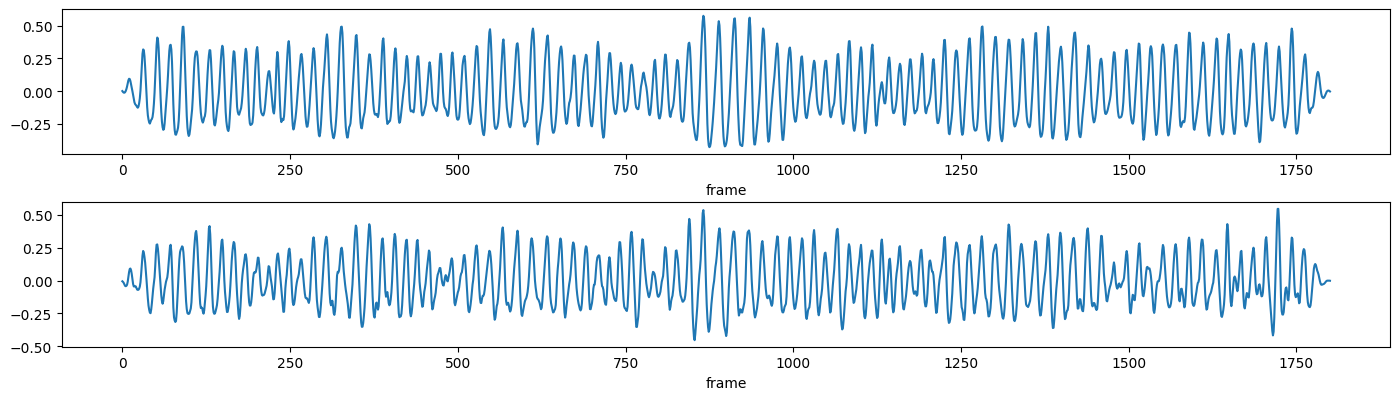

In [33]:
from matplotlib import pyplot as plt
plt.subplot(2,1,1)
plt.plot(rPPG[0][0])
plt.xlabel('frame')

plt.subplot(2,1,2)
plt.plot(rPPG[0][1])
plt.xlabel('frame')

plt.tight_layout()
plt.gcf().set_size_inches(15, 4)

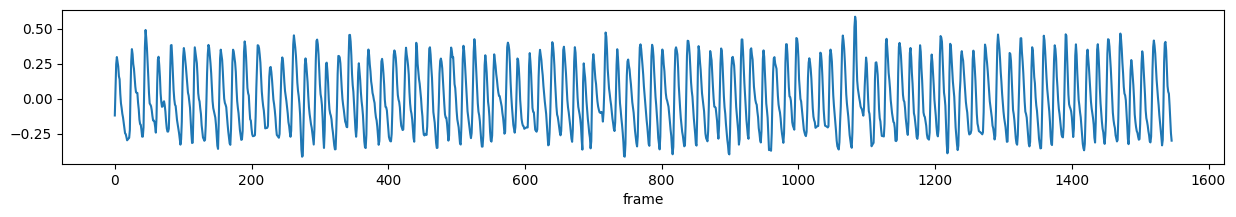

In [43]:
plt.plot(ground_truth_PPG[1])
plt.xlabel('frame')
plt.gcf().set_size_inches(15, 2)

In [46]:
print(len(rPPG[0][0]))
print(len(ground_truth_PPG[0]))

1801
1801
